# Handwritten Characters Classification

## Import Packages

In [1]:
import zipfile
import pickle
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
try:
  import keras_tuner as kt
except:
  !pip install keras-tuner --upgrade
  import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 16.2 MB/s eta 0:00:00


## Load Dataset

In [ ]:
# Function for download the dataset
def load_dataset():
  with zipfile.ZipFile('EMNIST_Byclass_Small.zip', 'r') as zip_file:
    # Unzip the zip file and extract all files into the current directory
    zip_file.extractall()

    # Open the train dataset
    with open('emnist_train.pkl', 'rb') as train_pkl:
      train_dataset = pickle.load(train_pkl)

    # Open the test dataset
    with open('emnist_test.pkl', 'rb') as test_pkl:
      test_dataset = pickle.load(test_pkl)
      
    return train_dataset, test_dataset

In [ ]:
# Extract training and test dataset
train_dataset, test_dataset = load_dataset()

# Split the training and test set into data and labels
X_train, y_train = train_dataset["data"], train_dataset["labels"]
X_test, y_test = test_dataset["data"], test_dataset["labels"]

print("Training data shape:", X_train.shape, "Training label shape:", y_train.shape)
print("Testing data shape:", X_test.shape, "Testing label shape:", y_test.shape)

Training data shape: (100000, 28, 28) Training label shape: (100000,)
Testing data shape: (20000, 28, 28) Testing label shape: (20000,)


## Dataset pre-processing

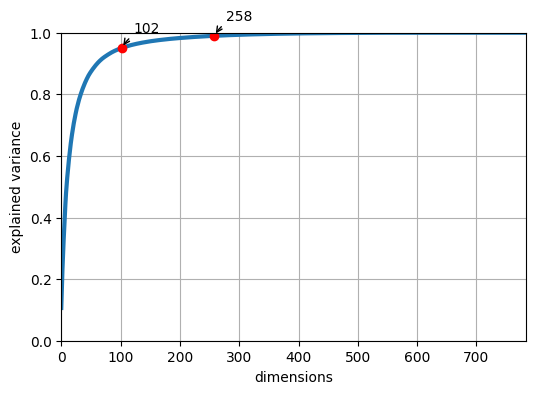

In [ ]:
"""Explore the feasibility of performing PCA for dimension reduction"""

# Principal component analysis
pca = PCA()
pca.fit(X_train.reshape(-1, X_train.shape[1] * X_train.shape[2]))
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance vs number of dimensions
plt.figure(figsize = (6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 784, 0, 1]) 
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)

# Add red dot and display the number of dimensions for explained variance = 0.95
idx = np.argwhere(cumsum >= 0.95)[0][0]
plt.plot(idx, cumsum[idx], 'ro')
plt.annotate(f"{idx}", (idx, cumsum[idx]), (idx+20, cumsum[idx]+0.05), 
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

# Add red dot and display the number of dimensions for explained variance = 0.99
idx1 = np.argwhere(cumsum >= 0.99)[0][0]
plt.plot(idx1, cumsum[idx1], 'ro')
plt.annotate(f"{idx1}", (idx1, cumsum[idx1]), (idx1+20, cumsum[idx1]+0.05), 
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.show()

In [ ]:
# Function for dataset pre-processing
def preprocessing(X_train, X_test):
    # Reshape / flatten the data into 1 dimension
    X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
    X_test = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

    # Normalize the data
    X_train_norm = X_train / 255
    X_test_norm = X_test / 255

    # Dimensional reduction using PCA
    pca = PCA(n_components=0.99)
    # Fit PCA with training data
    pca.fit(X_train_norm)

    # Transform training and testing data using the same PCA instance
    X_train_pca = pca.transform(X_train_norm)
    X_test_pca = pca.transform(X_test_norm)

    return X_train_pca, X_test_pca

In [ ]:
# Preprocess the image data
X_train, X_test = preprocessing(X_train, X_test)
print("After pre-processing:")
print("Train data shape:", X_train.shape, "Testing data shape:", X_test.shape)

After pre-processing:
Train data shape: (100000, 259) Testing data shape: (20000, 259)


## k-Nearest Neighbour

### Hyperparameter Tuning for kNN (Long runtime: **Approximately 4.14 hours**)

In [ ]:
"""Do not run - long runtime"""

# Hyperparameter tuning for kNN using Grid Search CV
def KNNClassifier_GridSearchCV(X_train, y_train):

    # Set up parameters grid to search 
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9],
                  'p': [1, 2]
                  }
    # Setting the 5 fold stratified cross-validation
    cvKFold=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Instantiate knn model
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, scoring='f1_weighted', cv=cvKFold, verbose=3)

    # Record the starting time
    start_time = time.time()

    # Fit the training data
    grid_search.fit(X_train, y_train)

    # Calculate the training time
    time_elapsed = time.time() - start_time

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best parameters found: ", best_params)
    print("Best accuracy found: ", best_score)
    print("Time elapsed: {:.2f} seconds".format(time_elapsed))

    return best_params


In [ ]:
"""Do not run - Has a long runtime"""

# Perform Grid Search CV for kNN
knn_best_params = KNNClassifier_GridSearchCV(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ................n_neighbors=1, p=1;, score=0.708 total time=10.0min
[CV 2/5] END ................n_neighbors=1, p=1;, score=0.710 total time=10.3min
[CV 3/5] END ................n_neighbors=1, p=1;, score=0.711 total time=10.6min
[CV 4/5] END ................n_neighbors=1, p=1;, score=0.709 total time= 9.3min
[CV 5/5] END ................n_neighbors=1, p=1;, score=0.708 total time= 9.4min
[CV 1/5] END ................n_neighbors=1, p=2;, score=0.741 total time=  31.0s
[CV 2/5] END ................n_neighbors=1, p=2;, score=0.742 total time=  30.9s
[CV 3/5] END ................n_neighbors=1, p=2;, score=0.744 total time=  32.3s
[CV 4/5] END ................n_neighbors=1, p=2;, score=0.742 total time=  30.9s
[CV 5/5] END ................n_neighbors=1, p=2;, score=0.739 total time=  33.6s
[CV 1/5] END ................n_neighbors=3, p=1;, score=0.706 total time= 9.2min
[CV 2/5] END ................n_neighbors=3, p=1;

In [ ]:
"""Long runtime"""
"""Do not run this code chunk unless the hyperparameter process code chunk has been executed in its entirety """

# Print out the best parameters for kNN
print("Best parameters for kNN:", knn_best_params)

Best parameters for kNN: {'n_neighbors': 5, 'p': 2}


### Build kNN classifier using best hyperparameters




In [ ]:
# kNN with best hyperparameters
knn_classifier = KNeighborsClassifier(n_neighbors = 5, 
                                      p = 2)

# Fit the knn classifier with the entire training data
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

### Model Evaluation for kNN classifier

In [ ]:
# Compute the predicted value for test set using knn 
knn_pred = knn_classifier.predict(X_test)

# Accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)

# Precision, Recall and F1-score
knn_precision, knn_recall, knn_f1, _ = precision_recall_fscore_support(y_test, knn_pred, average='weighted')

# Print result
print("k-Nearest Neighbour classifier accuracy: {:.4f}".format(knn_accuracy))
print("k-Nearest Neighbour classifier recall: {:.4f}".format(knn_recall))
print("k-Nearest Neighbour classifier precision {:.4f}".format(knn_precision))
print("k-Nearest Neighbour classifier F1-score: {:.4f}".format(knn_f1))

k-Nearest Neighbour classifier accuracy: 0.7705
k-Nearest Neighbour classifier recall: 0.7705
k-Nearest Neighbour classifier precision 0.7598
k-Nearest Neighbour classifier F1-score: 0.7545


In [ ]:
# Classificaiton report
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65       976
           1       0.57      0.86      0.69      1023
           2       0.88      0.93      0.90      1003
           3       0.91      0.97      0.94      1035
           4       0.87      0.93      0.90       903
           5       0.83      0.83      0.83       928
           6       0.90      0.96      0.93       959
           7       0.92      0.97      0.94      1098
           8       0.93      0.90      0.92       941
           9       0.87      0.95      0.91       929
          10       0.84      0.76      0.80       170
          11       0.89      0.26      0.41       118
          12       0.68      0.82      0.74       316
          13       0.84      0.41      0.55       128
          14       0.96      0.64      0.77       162
          15       0.76      0.70      0.73       261
          16       0.88      0.50      0.64        60
          17       0.74    

## Random Forest Classifier

### Hyperparameter Tuning for Random Forest (Long runtime: **Approximately 12.74 hours**)

In [ ]:
"""Long runtime"""

## Hyperparameter tuning for kNN using Grid Search CV
def RF_GridSearchCV(X_train, y_train):

    # Set up parameters grid to search 
    param_grid = {"n_estimators": [100, 200],
                  "max_features": ["sqrt", "log2"],
                  "max_depth": [5, 10]
                  }

    ## Setting the 5 fold stratified cross-validation
    cvKFold=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Instantiate Random Forest model
    rf = RandomForestClassifier(random_state = 0, criterion = "entropy", class_weight = "balanced")
    grid_search = GridSearchCV(rf, param_grid, scoring='f1_weighted', cv=cvKFold, verbose=3)

    # Record the starting time
    start_time = time.time()

    # Fit the training data
    grid_search.fit(X_train, y_train)

    # Calculate the training time
    time_elapsed = time.time() - start_time

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best parameters found: ", best_params)
    print("Best accuracy found: ", best_score)
    print("Time elapsed: {:.2f} seconds".format(time_elapsed))

    return best_params

In [ ]:
"""Long runtime"""

# Perform Grid Search CV for Random Forest classifier
rf_best_params = RF_GridSearchCV(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.472 total time=12.8min
[CV 2/5] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.480 total time=12.5min
[CV 3/5] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.475 total time=12.5min
[CV 4/5] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.475 total time=12.5min
[CV 5/5] END max_depth=5, max_features=sqrt, n_estimators=100;, score=0.478 total time=12.4min
[CV 1/5] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.485 total time=24.4min
[CV 2/5] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.488 total time=23.9min
[CV 3/5] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.490 total time=23.6min
[CV 4/5] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.489 total time=25.1min
[CV 5/5] END max_depth=5, max_features=sqrt, n_estimators=200;, score=0.486 total tim

In [ ]:
"""Do not run - long runtime"""
"""Do not run this code chunk unless the hyperparameter process code chunk has been executed in its entirety """

# Print out the best parameters for random forest classifier
print("Best parameters for Random Forest:", rf_best_params)

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


### Build Random Forest classifier using best hyperparameters (**Long runtime: Approximately 1 hour**)

In [ ]:
"""Long runtime: Approximately 1 hour"""

# Build Random Forest classifier with best hyperparameters
rf_classifier = RandomForestClassifier(n_estimators = 200, 
                        max_depth = 10,
                        max_features = "sqrt",
                        random_state = 0,
                        class_weight = "balanced", 
                        criterion = "entropy")

# Fit the Random Forest classifier with training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, n_estimators=200, random_state=0)

### Model evaluation for Random Forest Classifier

In [ ]:
# Compute the predicted value of y_pred using random forest classifier
rf_pred = rf_classifier.predict(X_test)

# Accuracy
rf_accuracy = accuracy_score(y_test, rf_pred)

# Precision, Recall and F1-Scre
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='weighted')

# Print result
print("Random Forest classifier accuracy: {:.4f}".format(rf_accuracy))
print("Random Forest classifier recall: {:.4f}".format(rf_recall))
print("Random Forest classifier precision {:.4f}".format(rf_precision))
print("Random Forest classifier F1-score: {:.4f}".format(rf_f1))

Random Forest classifier accuracy: 0.6142
Random Forest classifier recall: 0.6142
Random Forest classifier precision 0.6854
Random Forest classifier F1-score: 0.6306


In [ ]:
# Classificaiton report
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.67      0.58      0.62       976
           1       0.65      0.51      0.57      1023
           2       0.89      0.64      0.74      1003
           3       0.83      0.86      0.84      1035
           4       0.90      0.61      0.73       903
           5       0.86      0.55      0.67       928
           6       0.94      0.75      0.83       959
           7       0.86      0.89      0.88      1098
           8       0.91      0.61      0.73       941
           9       0.80      0.83      0.81       929
          10       0.47      0.77      0.59       170
          11       0.35      0.58      0.44       118
          12       0.66      0.35      0.46       316
          13       0.49      0.55      0.52       128
          14       0.57      0.64      0.61       162
          15       0.68      0.31      0.42       261
          16       0.34      0.73      0.46        60
          17       0.35    

## Multi Layer Perceptron

### Hyperparameter Tuning for Multi Layer Perceptron (**Approximately 7 minutes**)

In [ ]:
"""long runtime"""

def model_builder(hp):
  # Parameter
  input_size = X_train.shape[1]
  num_classes = len(Counter(y_train))

  # Define hyperparameters to search
  hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.5])

  # Define optimizer
  optimizer = AdamW(learning_rate=hp_learning_rate, weight_decay=0.001)

  # Define the loss function
  loss = SparseCategoricalCrossentropy()

  # Define the model
  model = Sequential()
  # first layer
  model.add(Dense(512, input_shape=(input_size,)))
  model.add(BatchNormalization())
  model.add(Activation(activation = hp_activation))
  model.add(Dropout(rate = hp_dropout_rate))
  # second layer
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation(activation = hp_activation))
  model.add(Dropout(rate = hp_dropout_rate))
  # third layer
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation(activation = hp_activation))
  model.add(Dropout(rate = hp_dropout_rate))
  # fourth layer
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation(activation = hp_activation))
  model.add(Dropout(rate = hp_dropout_rate))
  # output layer
  model.add(Dense(num_classes, activation='softmax'))

  # Compile model
  model.compile(optimizer= optimizer,
              loss= loss,
              metrics=['accuracy'])
  
  return model

In [ ]:
"""Long runtime"""

# Set up tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     seed = 0,
                     project_name='mlp_hyperparameter_tuning')

# Define early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Search best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])


Trial 12 Complete [00h 00m 43s]
val_accuracy: 0.7720000147819519

Best val_accuracy So Far: 0.797249972820282
Total elapsed time: 00h 06m 58s


In [ ]:
"""Long runtime"""
"""Do not run this code chunk unless the hyperparameter process code chunk has been executed in its entirety """

# Print the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Optimal activation funciton: {}".format(best_hp.get("activation")))
print("optimal learning rate: {}".format(best_hp.get("learning_rate")))
print("Optimal dropout rate: {}".format(best_hp.get("dropout_rate")))

Optimal activation funciton: relu
optimal learning rate: 0.001
Optimal dropout rate: 0.2


### Build Multi Layer Perceptron using best hyperparameters

In [ ]:
# Parameters
input_size = X_train.shape[1]
num_classes = len(Counter(y_train))

# Optimal parameters from hyperparameter tuning
opt_dropout_rate = 0.2
opt_learning_rate = 0.001
opt_activation = 'relu'

# Instantiate optimiser
optimizer = AdamW(learning_rate=opt_learning_rate, weight_decay=0.001)

# Define the loss function
loss = SparseCategoricalCrossentropy()

# Define the model using Keras
mlp_classifier = Sequential([
    # first layer
    Dense(512, input_shape=(input_size,)),
    BatchNormalization(),
    Activation(opt_activation),
    Dropout(opt_dropout_rate),
    # second layer
    Dense(256),
    BatchNormalization(),
    Activation(opt_activation),
    Dropout(opt_dropout_rate),
    # third layer
    Dense(256),
    BatchNormalization(),
    Activation(opt_activation),
    Dropout(opt_dropout_rate),
    # fourth layer
    Dense(128),
    BatchNormalization(),
    Activation(opt_activation),
    Dropout(opt_dropout_rate),
    # output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
mlp_classifier.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# Set validation set ratio
val_ratio = 0.1

# Split the training data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, random_state=0)

# Check the data shape for the training and validation set
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

X_train: (90000, 259)
X_val: (10000, 259)
X_test: (20000, 259)


In [ ]:
# Set up random seed
tf.random.set_seed(0)

# Define the batch size and number of epochs
batch_size = 256
epochs = 30

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = mlp_classifier.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/30
352/352 [==============================] - 6s 7ms/step - loss: 1.5466 - accuracy: 0.6017 - val_loss: 0.7988 - val_accuracy: 0.7571
Epoch 2/30
352/352 [==============================] - 2s 7ms/step - loss: 0.8663 - accuracy: 0.7319 - val_loss: 0.6261 - val_accuracy: 0.7946
Epoch 3/30
352/352 [==============================] - 2s 6ms/step - loss: 0.7315 - accuracy: 0.7663 - val_loss: 0.5705 - val_accuracy: 0.8076
Epoch 4/30
352/352 [==============================] - 2s 6ms/step - loss: 0.6592 - accuracy: 0.7834 - val_loss: 0.5357 - val_accuracy: 0.8183
Epoch 5/30
352/352 [==============================] - 2s 6ms/step - loss: 0.6162 - accuracy: 0.7943 - val_loss: 0.5209 - val_accuracy: 0.8254
Epoch 6/30
352/352 [==============================] - 2s 6ms/step - loss: 0.5781 - accuracy: 0.8032 - val_loss: 0.4986 - val_accuracy: 0.8291
Epoch 7/30
352/352 [==============================] - 2s 7ms/step - loss: 0.5498 - accuracy: 0.8119 - val_loss: 0.4900 - val_accuracy: 0.8323
Epoch 

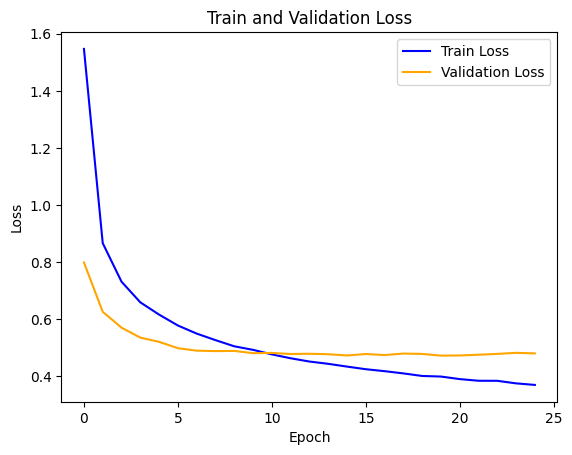

In [ ]:
# Plot train and validation loss after all epochs
plt.figure()
plt.plot(history.history['loss'], label="Train Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()

### Model evaluation for Multi Layer Perceptron classifier

In [ ]:
# Evaluate the model
mlp_loss, mlp_accuracy = mlp_classifier.evaluate(X_test, y_test, verbose=0)

# Calculate predictions for the test dataset
mlp_pred = mlp_classifier.predict(X_test)
mlp_pred = np.argmax(mlp_pred, axis=1)

mlp_precision, mlp_recall, mlp_f1_score, _ = precision_recall_fscore_support(y_test, mlp_pred, average='weighted')

print(f"Test Loss: {mlp_loss:.4f}, Test Acc: {mlp_accuracy:.4f}")
print(f"Precision: {mlp_precision:.4f}, Recall: {mlp_recall:.4f}, F1-score: {mlp_f1_score:.4f}")

625/625 [==============================] - 1s 1ms/step
Test Loss: 0.5019, Test Acc: 0.8363
Precision: 0.8228, Recall: 0.8363, F1-score: 0.8184


In [ ]:
# Classification report
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73       976
           1       0.65      0.94      0.77      1023
           2       0.94      0.94      0.94      1003
           3       0.97      0.98      0.97      1035
           4       0.92      0.97      0.94       903
           5       0.88      0.91      0.89       928
           6       0.96      0.96      0.96       959
           7       0.98      0.98      0.98      1098
           8       0.95      0.96      0.96       941
           9       0.92      0.97      0.94       929
          10       0.89      0.89      0.89       170
          11       0.82      0.83      0.82       118
          12       0.73      0.92      0.81       316
          13       0.84      0.84      0.84       128
          14       0.93      0.88      0.90       162
          15       0.79      0.90      0.85       261
          16       0.81      0.78      0.80        60
          17       0.83    

## Imbalance classes prediction

In [ ]:
# get classification report dictionary
def extract_classification_report(y_true, y_pred):
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    
    # delete keys
    report_dict.pop('accuracy', None)
    report_dict.pop('macro avg', None)
    report_dict.pop('weighted avg', None)
    
    return report_dict

report_dict = extract_classification_report(y_test, mlp_pred)

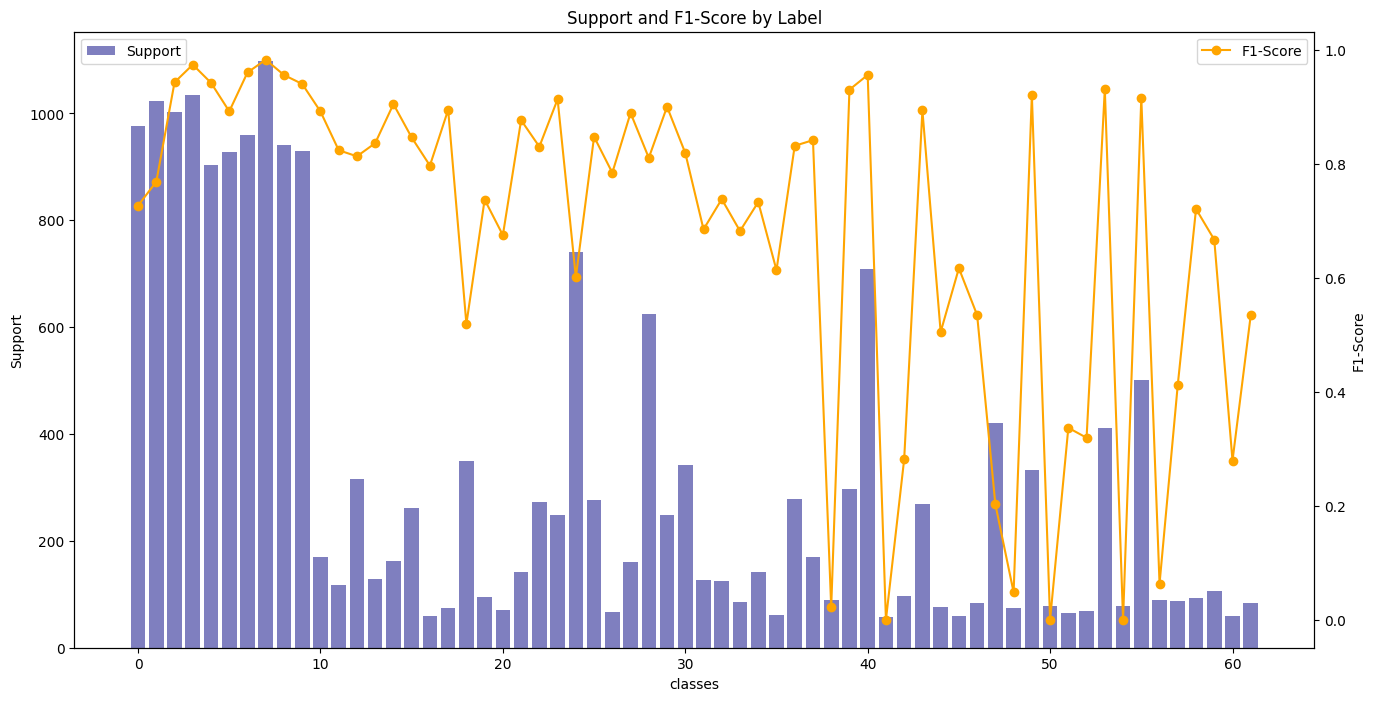

In [ ]:
import matplotlib.pyplot as plt

def plot_report(report_dict):
    classes = []
    f1_scores = []
    supports = []

    for class_id, info in report_dict.items():
        classes.append(int(class_id))
        f1_scores.append(info['f1-score'])
        supports.append(info['support'])

    fig, ax1 = plt.subplots(figsize=(16, 8))


    ax1.bar(classes, supports, alpha=0.5, color='navy', label='Support')
    ax1.set_xlabel('classes')
    ax1.set_ylabel('Support')


    ax2 = ax1.twinx()
    ax2.plot(classes, f1_scores, color='orange', marker='o', label='F1-Score')
    ax2.set_ylabel('F1-Score')
    plt.title('Support and F1-Score by Label')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()


plot_report(report_dict)


## Model comparison

In [3]:
# Model performance comparison dictionary
"""Input the value directly instead of calling each variable 
to avoid long runtime for fitting each model every time."""

# Store models performance in dictionary
models_performance = {"kNN":{"Accuracy":0.7705, "Precision":0.7598, "Recall": 0.7705, 
                             "F1-Score": 0.7545, "Tuning time":14896.85}, 
                      "Random Forest":{"Accuracy":0.6142, "Precision":0.6854, "Recall": 0.6142, 
                                       "F1-Score": 0.6306, "Tuning time":45863.90},
                      "Multi Layer Perceptron":{"Accuracy":0.8363, "Precision":0.8228, "Recall": 0.8363, 
                                       "F1-Score": 0.8184, "Tuning time":418.0}
                      }

# Connvert dictionary to datafrmae
comparison_df = pd.DataFrame(models_performance)
comparison_df

,kNN,Random Forest,Multi Layer Perceptron
Accuracy,0.7705,0.6142,0.8363
Precision,0.7598,0.6854,0.8228
Recall,0.7705,0.6142,0.8363
F1-Score,0.7545,0.6306,0.8184
Tuning time,14896.8500,45863.9000,418.0000
